# Advanced MLDL Course  - Assignment 1
## group006 : Lilach Cohen, Daniel Yohan, Amit Carsenti

# Imports

In [1]:
#Imports
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import time as clock

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from collections import OrderedDict

import xgboost as xgb
from xgboost import plot_importance

Import the data

In [2]:
url_train = 'https://raw.githubusercontent.com/lilachc/AdvancedMLDLCourse_Assignment_1_group006/main/train.csv'
url_test = 'https://raw.githubusercontent.com/lilachc/AdvancedMLDLCourse_Assignment_1_group006/main/test.csv'

# Train
df1 = pd.read_csv(url_train)

#df2 is for visualizations
df2 = df1.copy()

# Data Exploration, Understanding, and Visualization

In [3]:
df1

datetime  season  holiday  workingday  weather   temp  \
0     2011-07-11 00:00:00       3        0           1        1  28.70   
1     2012-05-18 22:00:00       2        0           1        1  22.96   
2     2011-04-01 23:00:00       2        0           1        1  12.30   
3     2012-09-16 09:00:00       3        0           0        1  23.78   
4     2011-02-01 23:00:00       1        0           1        3   8.20   
...                   ...     ...      ...         ...      ...    ...   
8159  2012-01-14 02:00:00       1        0           0        1   6.56   
8160  2011-12-10 09:00:00       4        0           0        1  11.48   
8161  2011-12-18 16:00:00       4        0           0        1  11.48   
8162  2011-02-19 07:00:00       1        0           0        1  15.58   
8163  2012-05-02 07:00:00       2        0           1        2  22.14   

       atemp  humidity  windspeed  pollution  sunlight   traffic  count  
0     32.575        65    12.9980   5.354100    28.701  0.000000     35  
1     26.515        52    22.0028  85.425233    22.961  0.004489    251  
2     15.910        61     6.0032   2.040899    12.301  0.000242     53  
3     27.275        60     8.9981  26.682772    23.781  0.004489    296  
4      9.850        93    12.9980   5.851754     8.201  0.000000     16  
...      ...       ...        ...        ...       ...       ...    ...  
8159   8.335        47    11.0014  14.953355     6.561  0.004489     38  
8160  12.880        61    19.0012   7.977025    11.481  0.000000    149  
8161  13.635        48    16.9979   6.916512    11.481  0.015615    234  
8162  19.695        17    35.0008   0.095445    15.581  0.000242     22  
8163  25.760        88    12.9980  81.965417    22.141  0.015615    358  

[8164 rows x 13 columns]

# Feature Engineering

In [4]:
# Dealing with datetime feature:
uniques , counts = np.unique(df1['datetime'], return_counts = True)
print(len(uniques))
#we can see that this feature in this form is irreleven for our model, we will extract information and create new features

df1['datetime_col'] = pd.to_datetime(df1['datetime'])
df1['hour'] = df1['datetime_col'].dt.hour
df1 = df1.drop(columns=['datetime'])

# Create dummy for 2011
def create_dummy_year(df):
  df['is_2011'] = df['datetime_col'].dt.year.apply(lambda x: 1 if x == 2011 else 0)

create_dummy_year(df1)

# Drop 'datetime_col' column
df1 = df1.drop(columns=['datetime_col'])

# Cyclical encoding

# Hours
df1['hour_sin'] = np.sin(2 * np.pi * df1['hour'] / 24)
df1['hour_cos'] = np.cos(2 * np.pi * df1['hour'] / 24)


# Rename the label 'count' with 'rentals'
df1.rename(columns={'count':'rentals'}, inplace=True)

# Displaying the DataFrame
print(df1)

8164
      season  holiday  workingday  weather   temp   atemp  humidity  \
0          3        0           1        1  28.70  32.575        65   
1          2        0           1        1  22.96  26.515        52   
2          2        0           1        1  12.30  15.910        61   
3          3        0           0        1  23.78  27.275        60   
4          1        0           1        3   8.20   9.850        93   
...      ...      ...         ...      ...    ...     ...       ...   
8159       1        0           0        1   6.56   8.335        47   
8160       4        0           0        1  11.48  12.880        61   
8161       4        0           0        1  11.48  13.635        48   
8162       1        0           0        1  15.58  19.695        17   
8163       2        0           1        2  22.14  25.760        88   

      windspeed  pollution  sunlight   traffic  rentals  hour  is_2011  \
0       12.9980   5.354100    28.701  0.000000       35     0       

In [5]:
# Create dummies for season
dummy_variables = pd.get_dummies(df1['season'], prefix='season')
df1 = pd.concat([df1, dummy_variables], axis=1)
#df1 = df1.drop('season', axis=1)

# Create dummies for weather
dummy_variables = pd.get_dummies(df1['weather'], prefix='weather')
df1 = pd.concat([df1, dummy_variables], axis=1)
#df1 = df1.drop('weather', axis=1)




In [6]:
# Move rental to the rightmost column
df1['rentals'] = df1.pop('rentals')

In [7]:
df1

season  holiday  workingday  weather   temp   atemp  humidity  \
0          3        0           1        1  28.70  32.575        65   
1          2        0           1        1  22.96  26.515        52   
2          2        0           1        1  12.30  15.910        61   
3          3        0           0        1  23.78  27.275        60   
4          1        0           1        3   8.20   9.850        93   
...      ...      ...         ...      ...    ...     ...       ...   
8159       1        0           0        1   6.56   8.335        47   
8160       4        0           0        1  11.48  12.880        61   
8161       4        0           0        1  11.48  13.635        48   
8162       1        0           0        1  15.58  19.695        17   
8163       2        0           1        2  22.14  25.760        88   

      windspeed  pollution  sunlight  ...  hour_cos  season_1  season_2  \
0       12.9980   5.354100    28.701  ...  1.000000         0         0   
1       22.0028  85.425233    22.961  ...  0.866025         0         1   
2        6.0032   2.040899    12.301  ...  0.965926         0         1   
3        8.9981  26.682772    23.781  ... -0.707107         0         0   
4       12.9980   5.851754     8.201  ...  0.965926         1         0   
...         ...        ...       ...  ...       ...       ...       ...   
8159    11.0014  14.953355     6.561  ...  0.866025         1         0   
8160    19.0012   7.977025    11.481  ... -0.707107         0         0   
8161    16.9979   6.916512    11.481  ... -0.500000         0         0   
8162    35.0008   0.095445    15.581  ... -0.258819         1         0   
8163    12.9980  81.965417    22.141  ... -0.258819         0         1   

      season_3  season_4  weather_1  weather_2  weather_3  weather_4  rentals  
0            1         0          1          0          0          0       35  
1            0         0          1          0          0          0      251  
2            0         0          1          0          0          0       53  
3            1         0          1          0          0          0      296  
4            0         0          0          0          1          0       16  
...        ...       ...        ...        ...        ...        ...      ...  
8159         0         0          1          0          0          0       38  
8160         0         1          1          0          0          0      149  
8161         0         1          1          0          0          0      234  
8162         0         0          1          0          0          0       22  
8163         0         0          0          1          0          0      358  

[8164 rows x 24 columns]

In [8]:
#arrange everything weve done in functions for later use on the test set
def tidy_dataset(df):

  df['datetime_col'] = pd.to_datetime(df['datetime'])
  df['hour'] = df['datetime_col'].dt.hour

  #df1['month'] = df1['datetime_col'].dt.month
  df = df.drop(columns=['datetime'])

  # Hours
  df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
  df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)


  # Create dummy for 2011
  df['is_2011'] = df['datetime_col'].dt.year.apply(lambda x: 1 if x == 2011 else 0)

  # Rename the label 'count' with 'rentals'
  df.rename(columns={'count':'rentals'}, inplace=True)

  # Drop 'datetime_col' column
  df = df.drop(columns=['datetime_col'])

  # Displaying the DataFrame

  return df


def create_dummies(df1):

  # Create dummies for season
  dummy_variables = pd.get_dummies(df1['season'], prefix='season')
  df1 = pd.concat([df1, dummy_variables], axis=1)
  #df1 = df1.drop('season', axis=1)

  # Create dummies for weather
  dummy_variables = pd.get_dummies(df1['weather'], prefix='weather')
  df1 = pd.concat([df1, dummy_variables], axis=1)
  #df1 = df1.drop('weather', axis=1)
  return df1

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      8164 non-null   int64  
 1   holiday     8164 non-null   int64  
 2   workingday  8164 non-null   int64  
 3   weather     8164 non-null   int64  
 4   temp        8164 non-null   float64
 5   atemp       8164 non-null   float64
 6   humidity    8164 non-null   int64  
 7   windspeed   8164 non-null   float64
 8   pollution   8164 non-null   float64
 9   sunlight    8164 non-null   float64
 10  traffic     8164 non-null   float64
 11  hour        8164 non-null   int64  
 12  is_2011     8164 non-null   int64  
 13  hour_sin    8164 non-null   float64
 14  hour_cos    8164 non-null   float64
 15  season_1    8164 non-null   uint8  
 16  season_2    8164 non-null   uint8  
 17  season_3    8164 non-null   uint8  
 18  season_4    8164 non-null   uint8  
 19  weather_1   8164 non-null  

In [10]:
df1.describe()

season      holiday   workingday      weather         temp  \
count  8164.000000  8164.000000  8164.000000  8164.000000  8164.000000   
mean      2.510289     0.029397     0.683244     1.415483    20.244980   
std       1.117178     0.168928     0.465240     0.631242     7.796018   
min       1.000000     0.000000     0.000000     1.000000     0.820000   
25%       2.000000     0.000000     0.000000     1.000000    13.940000   
50%       3.000000     0.000000     1.000000     1.000000    20.500000   
75%       4.000000     0.000000     1.000000     2.000000    26.240000   
max       4.000000     1.000000     1.000000     4.000000    41.000000   

             atemp     humidity    windspeed    pollution     sunlight  ...  \
count  8164.000000  8164.000000  8164.000000  8164.000000  8164.000000  ...   
mean     23.670160    61.835130    12.791334    47.152120    20.245980  ...   
std       8.468725    19.255791     8.213914    72.882602     7.796018  ...   
min       0.760000     0.000000     0.000000     0.000304     0.821000  ...   
25%      16.665000    47.000000     7.001500     3.693188    13.941000  ...   
50%      24.240000    62.000000    12.998000    17.684113    20.501000  ...   
75%      31.060000    77.000000    16.997900    59.257746    26.241000  ...   
max      45.455000   100.000000    56.996900   754.304876    41.001000  ...   

           hour_cos     season_1     season_2     season_3     season_4  \
count  8.164000e+03  8164.000000  8164.000000  8164.000000  8164.000000   
mean   2.167994e-03     0.245835     0.251225     0.249755     0.253185   
std    7.056879e-01     0.430608     0.433744     0.432898     0.434862   
min   -1.000000e+00     0.000000     0.000000     0.000000     0.000000   
25%   -7.071068e-01     0.000000     0.000000     0.000000     0.000000   
50%   -1.836970e-16     0.000000     0.000000     0.000000     0.000000   
75%    7.071068e-01     0.000000     1.000000     0.000000     1.000000   
max    1.000000e+00     1.000000     1.000000     1.000000     1.000000   

         weather_1    weather_2    weather_3    weather_4      rentals  
count  8164.000000  8164.000000  8164.000000  8164.000000  8164.000000  
mean      0.662175     0.260289     0.077413     0.000122   191.339784  
std       0.472997     0.438819     0.267262     0.011067   181.143178  
min       0.000000     0.000000     0.000000     0.000000     1.000000  
25%       0.000000     0.000000     0.000000     0.000000    41.000000  
50%       1.000000     0.000000     0.000000     0.000000   145.000000  
75%       1.000000     1.000000     0.000000     0.000000   285.000000  
max       1.000000     1.000000     1.000000     1.000000   970.000000  

[8 rows x 24 columns]

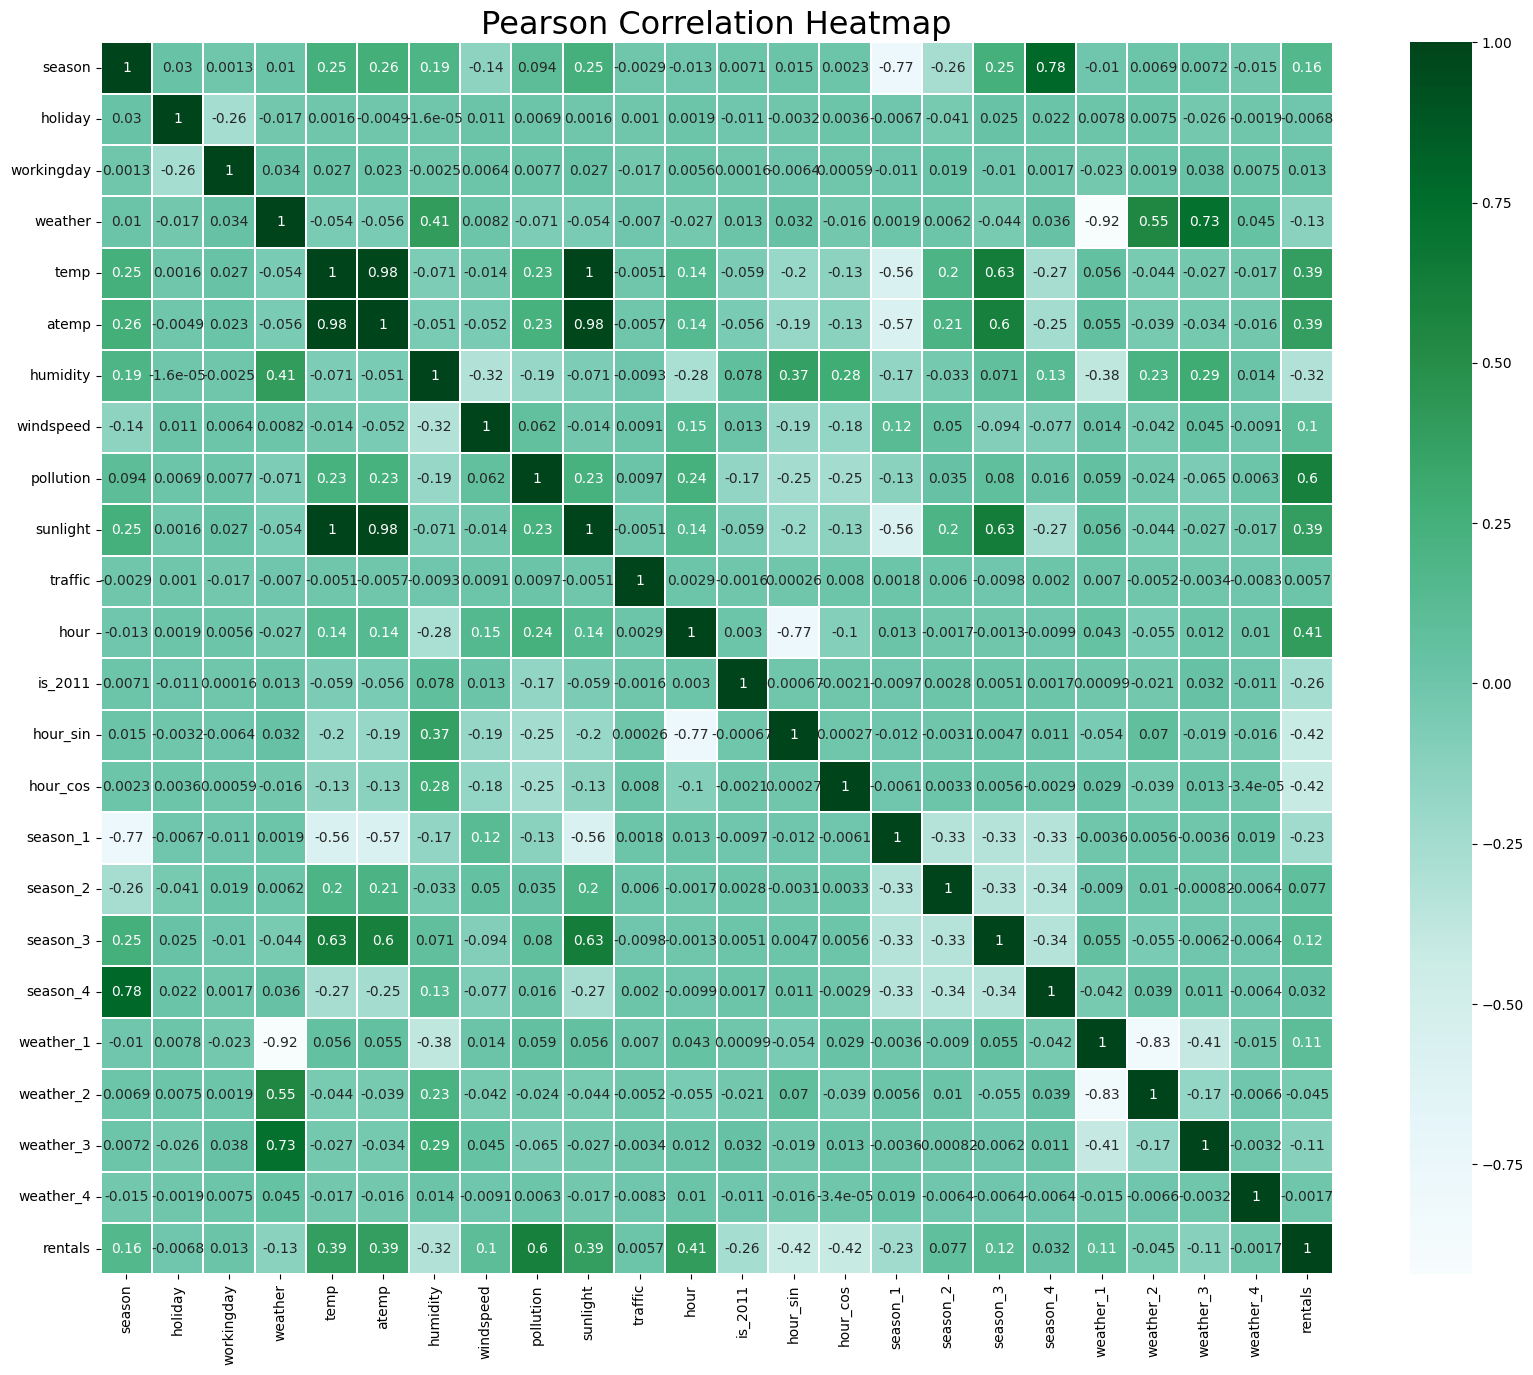

In [11]:
#Pearson's correlation matrix of all features

corr_df = df1.corr()

fig, ax = plt.subplots(figsize=(20, 16))
plt.title('Pearson Correlation Heatmap', fontsize=23)

sns.heatmap(corr_df, linewidths=0.25, vmax=1.0, square=True, cmap="BuGn",
            linecolor='w', annot=True)

plt.show()

## Visualizations

Looking further into the features that are significantly correlated with the target.

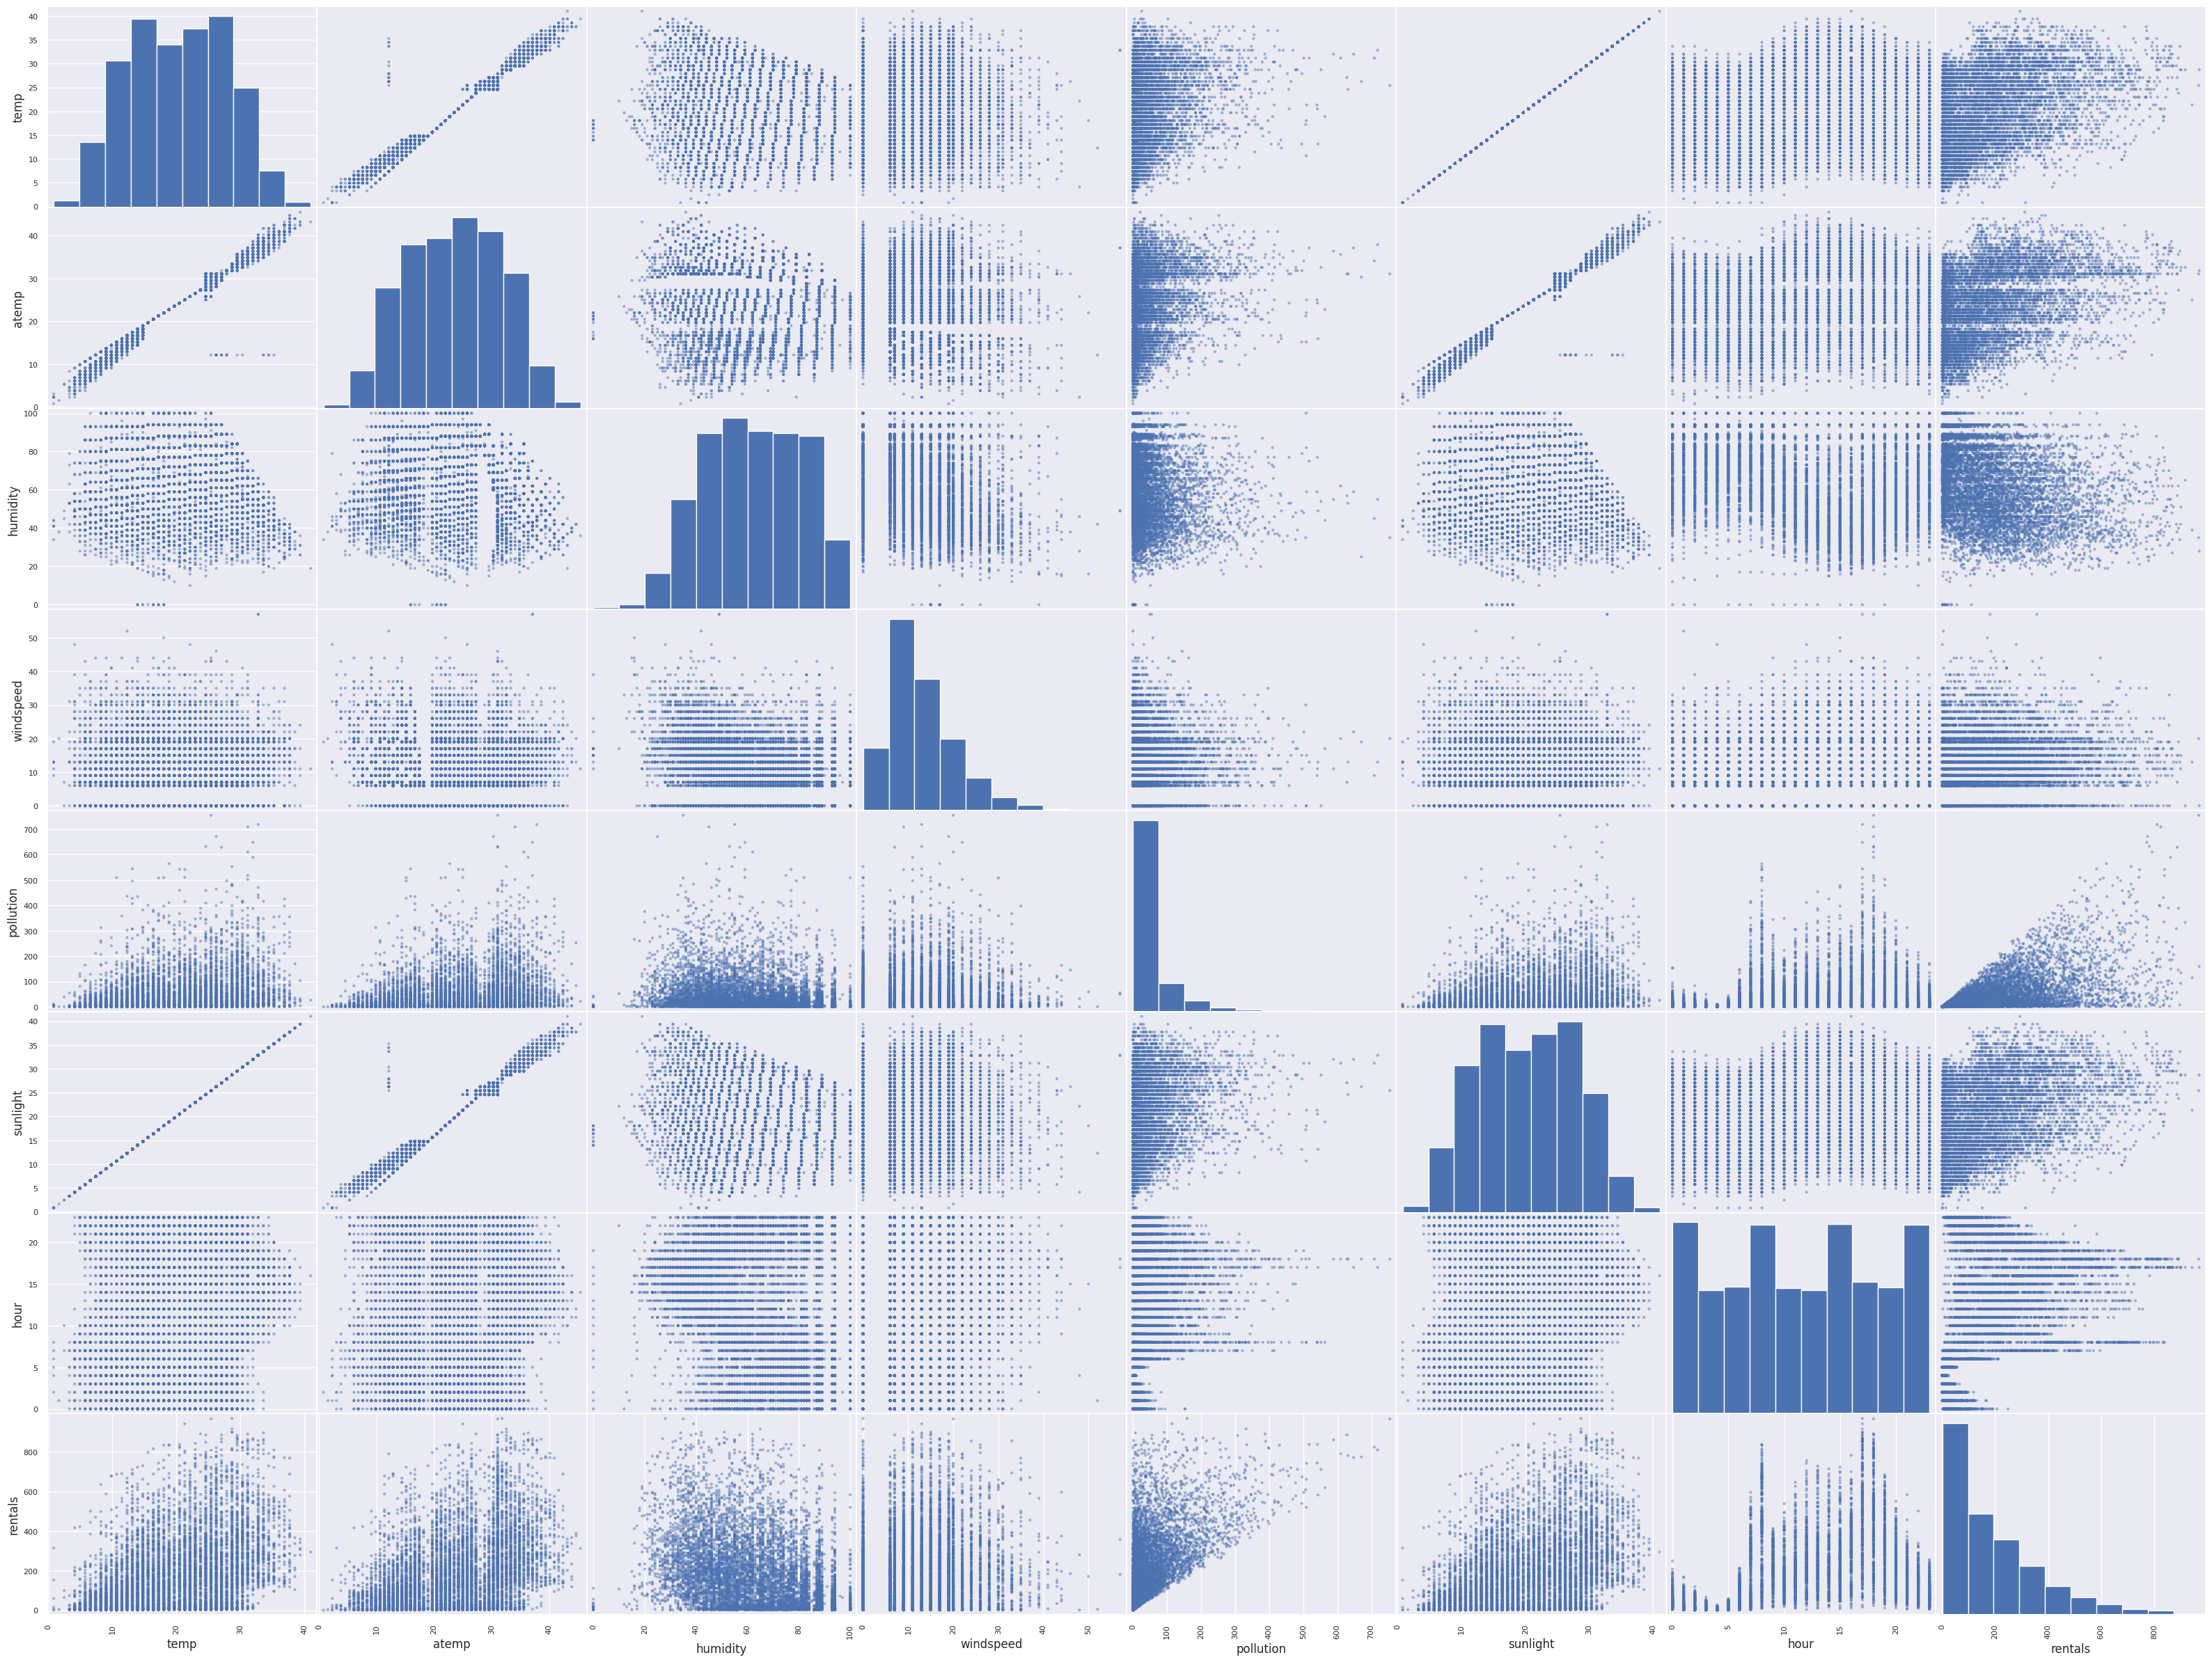

In [12]:
features_to_display = ['temp', 'atemp', 'humidity', 'windspeed', 'pollution', 'sunlight', 'hour', 'rentals']

sns.set()
pd.plotting.scatter_matrix(df1[features_to_display], alpha=0.5, figsize=(40, 30))
plt.show()

In [13]:
# Creating lists acording to feature type

#list of numeric features
numeric = ['temp', 'atemp', 'humidity', 'windspeed', 'pollution', 'sunlight', ]
#list of binary features
binary = ['holiday', 'workingday','traffic', 'season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4','is_2011']
#list of time features
time = ['hour', 'hour_sin', 'hour_cos', ]


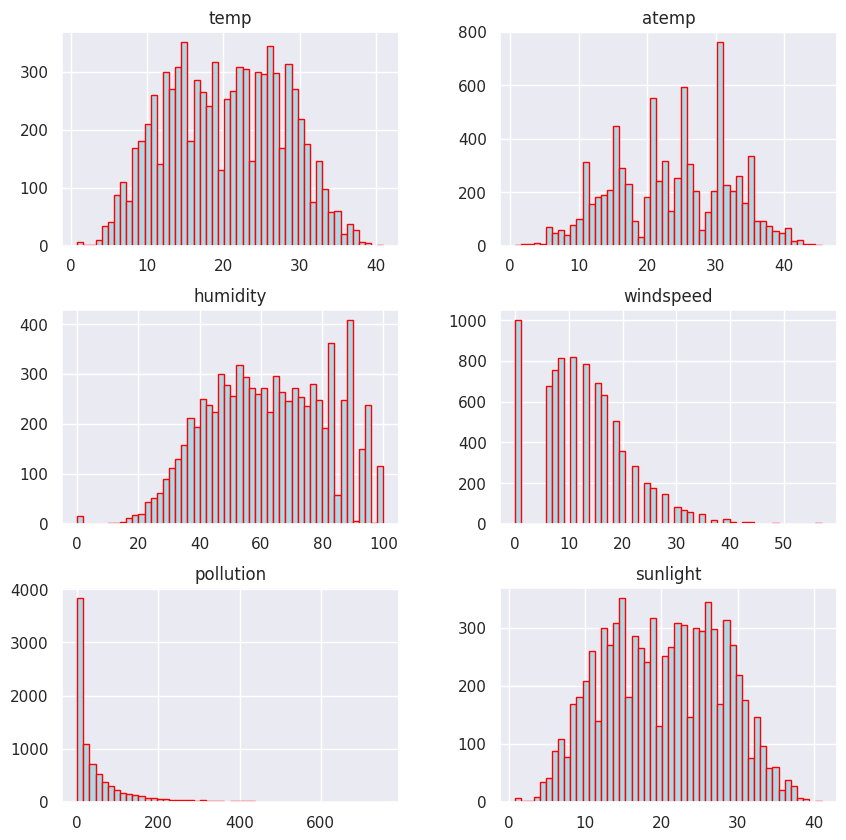

In [14]:
# Histograms for all continuous features

df1.loc[:, numeric].hist(bins = 50, figsize=(10, 10), color='lightblue', edgecolor='red')

plt.show()

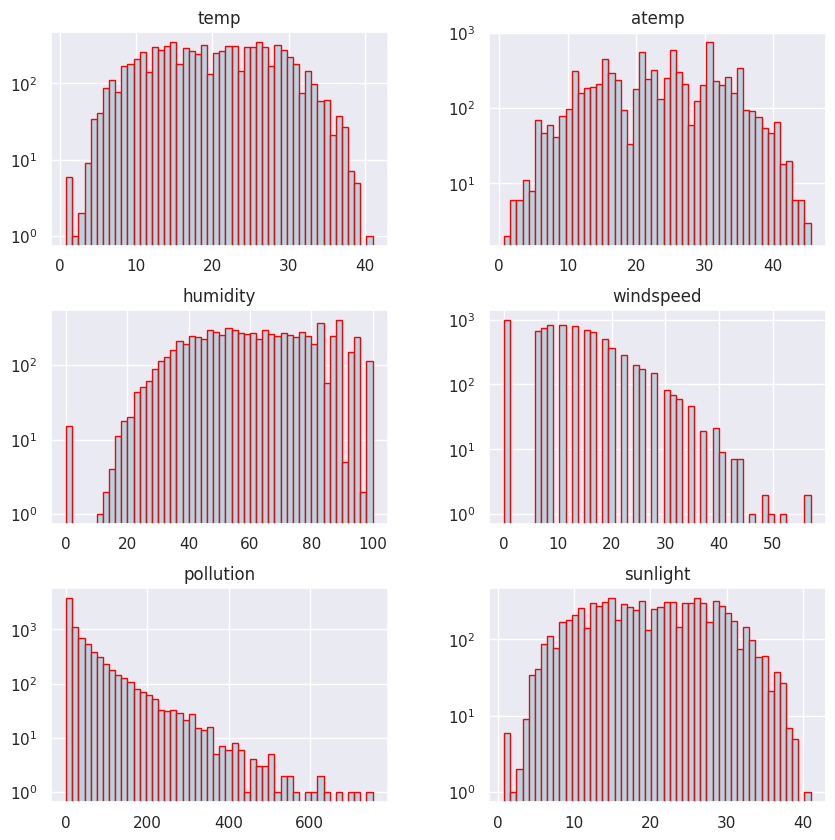

In [15]:
#Histograms for all log of features

df1.loc[:, numeric].hist(bins = 50, figsize=(10, 10), color='lightblue', edgecolor='red', log = True)

plt.show()

#### Let's have a better look at time veriables vs. rentals and temperatures vs. rentals

In [16]:
# Work on a different df beacuse datetime was dropped
df2['datetime'] = pd.to_datetime(df2['datetime'])
df2.rename(columns={'count':'rentals'}, inplace=True)

In [17]:
# Hour and rentals
df_groupby_hour = df2[['datetime', 'rentals']].copy()
df_groupby_hour['datetime'] = df_groupby_hour['datetime'].dt.hour
df_groupby_hour.rename(columns={'datetime':'hour'}, inplace=True)
df_groupby_hour = df_groupby_hour.groupby('hour').sum()

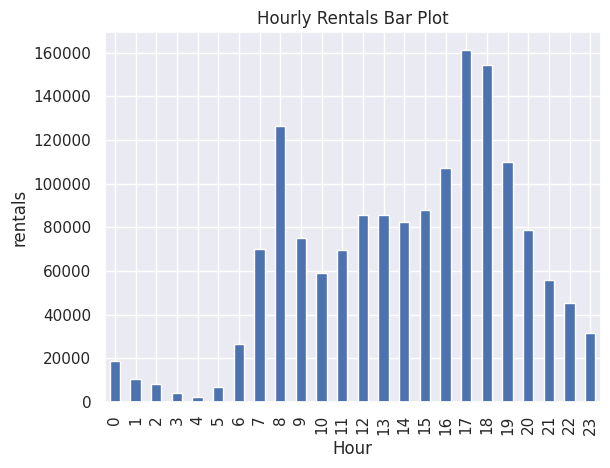

In [18]:
df_groupby_hour.plot(kind='bar', legend=False)
plt.xlabel('Hour')
plt.ylabel('rentals')
plt.title('Hourly Rentals Bar Plot')
plt.show()

In [19]:
# Months, years vs. rentals
df_groupby_month = df2[['datetime', 'rentals']].copy()
df_groupby_month['month'] = df_groupby_month['datetime'].dt.month
df_groupby_month['year'] = df_groupby_month['datetime'].dt.year
df_groupby_month.drop('datetime', axis=1, inplace=True)
df_groupby_month = df_groupby_month.groupby(['year', 'month']).agg({'rentals': 'sum'}).reset_index()

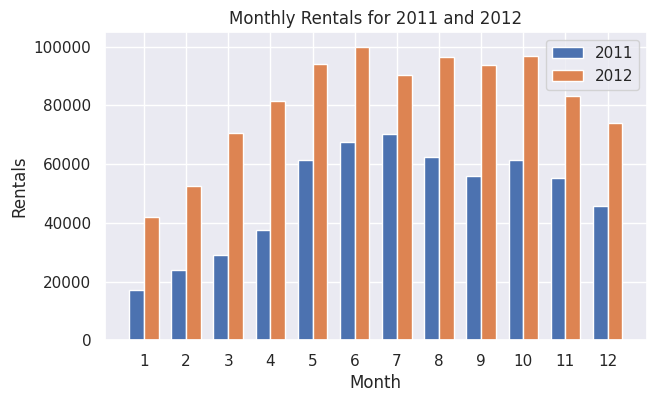

In [20]:
# Filter data for 2011 and 2012
df_2011 = df_groupby_month[df_groupby_month['year'] == 2011]
df_2012 = df_groupby_month[df_groupby_month['year'] == 2012]

# Plotting
bar_width = 0.35
bar_spacing = 0.2

fig, ax = plt.subplots(figsize=(7, 4))

bar_2011 = ax.bar(df_2011['month'] - bar_width/2, df_2011['rentals'], bar_width, label='2011')
bar_2012 = ax.bar(df_2012['month'] + bar_width/2, df_2012['rentals'], bar_width, label='2012')

ax.set_xlabel('Month')
ax.set_ylabel('Rentals')
ax.set_title('Monthly Rentals for 2011 and 2012')
ax.set_xticks(df_groupby_month['month'].unique())  # Use unique months from both years
ax.legend()

plt.show()

In [21]:
# Temperatures and rentals
df_groupby_temp = df2[['temp', 'rentals']].copy()

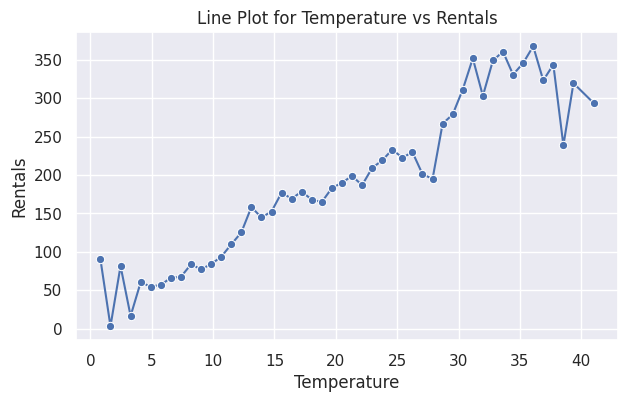

In [22]:
# 1. Create a line plot of temp vs. rentals
plt.figure(figsize=(7, 4))
sns.lineplot(x='temp', y='rentals', data=df_groupby_temp, marker='o', errorbar=None)
plt.xlabel('Temperature')
plt.ylabel('Rentals')
plt.title('Line Plot for Temperature vs Rentals')
plt.show()


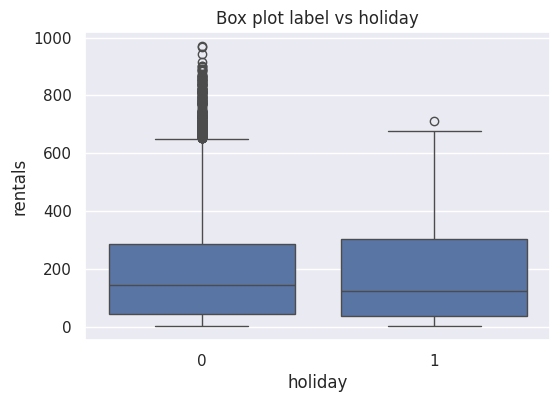

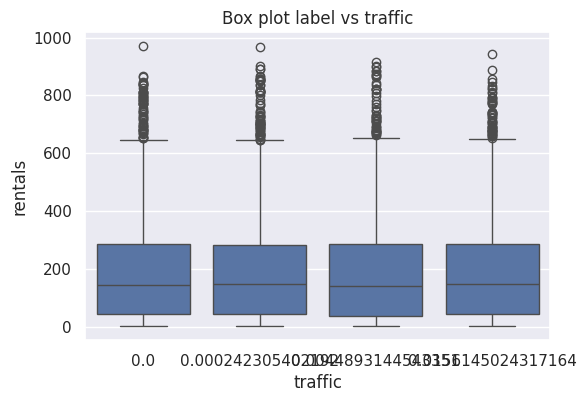

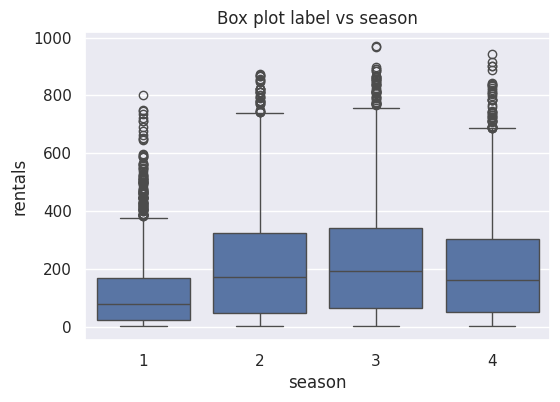

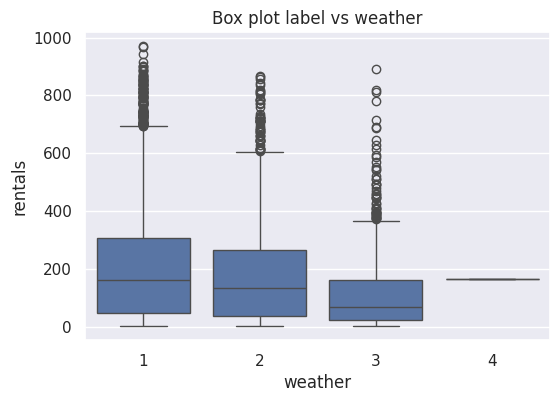

In [23]:
box_feat_list = ['holiday', 'traffic', 'season', 'weather']
for col in box_feat_list:
    fig , ax = plt.subplots(figsize=(6,4))
    sns.boxplot(x= col, y= 'rentals' ,data=df2)
    plt.title("Box plot label vs %s" % (col))
    plt.show()

In [24]:
# Split the label from the features
X = df1.drop(['rentals'], axis=1)
Y = df1[['rentals']]

In [25]:
# Split to train and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [26]:
def scaling_data (train , test):
    sc = StandardScaler()
    return pd.DataFrame(sc.fit_transform(train)), pd.DataFrame(sc.transform(test))

# Scaling with standart scaler
X_train, X_test = scaling_data(X_train, X_test)

# Modeling

In [27]:
def run_random_forest(x_train, y_train):
    rf = RandomForestRegressor(n_estimators=500,  # Increase the number of trees
                               random_state=42)
    tuned_rf = GridSearchCV(estimator=rf,
                            param_grid={'max_features': ['auto', 'sqrt', 'log2'],'min_samples_split': [2, 5, 10],'max_depth': [7,8,10], },
                            scoring='neg_mean_squared_error',
                            cv=5,
                            verbose=3,
                            refit=True, n_jobs=-1)
    tuned_rf.fit(x_train, y_train)
    print(tuned_rf.best_params_)
    return tuned_rf

In [28]:
def run_xgboost_regression(x_train, y_train):
  xg = xgb.XGBRegressor()
  tuned_xg = GridSearchCV(estimator=xg,
  param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
                                        'objective':['reg:linear'],
                                        'learning_rate': [0.03, 0.05, 0.07], #so called eta value
                                        'max_depth': [5, 6, 7],
                                        'min_child_weight': [1, 5, 10],
                                        'silent': [1],
                                        'subsample': [0.7],
                                        'colsample_bytree': [0.7],
                                        'n_estimators': [500]},
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=3, refit=True, n_jobs=-1)
  tuned_xg.fit(x_train, np.ravel(y_train))
  print(tuned_xg.best_params_)
  return tuned_xg

In [29]:
def run_ridge_regression(x_train, y_train):
  rr = Ridge()
  tuned_rr = GridSearchCV(estimator=rr,
                          param_grid={'alpha': [0.05, 0.1, 0.5, 1.0, 10.0, 100.0]},
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=3, refit=True, n_jobs=-1)
  tuned_rr.fit(x_train, np.ravel(y_train))
  return tuned_rr

In [30]:
def run_all_models(x, y):
  models_dict = {}
  models_dict['Random forest'] = run_random_forest(x, y)
  models_dict['xgboost'] = run_xgboost_regression(x, y)
  models_dict['Ridge Regression'] = run_ridge_regression(x, y)
  return models_dict

In [31]:
models = run_all_models(X_train, Y_train.values.ravel())

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 2}
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:34:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:34:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


### Determine Cross Validation RMSE

In [32]:
def get_cv_scores(model):
  cv_scores = {}
  for key, value in model.items():
    cv_scores[key] = value.best_score_
  return cv_scores

In [33]:
def get_best_estimators(model):
  best_estimators = {}
  for key, value in model.items():
    best_estimators[key] = value.best_estimator_

  return best_estimators

In [34]:
cv_scores_models = get_cv_scores(models)
best_est_models = get_best_estimators(models)

In [35]:
def display_predictions(model):
  sns.set()
  cv_scores_df = (pd.DataFrame.from_dict(model, orient='index'))
  cv_scores_df.plot.bar(rot=45, legend=False)
  plt.show()

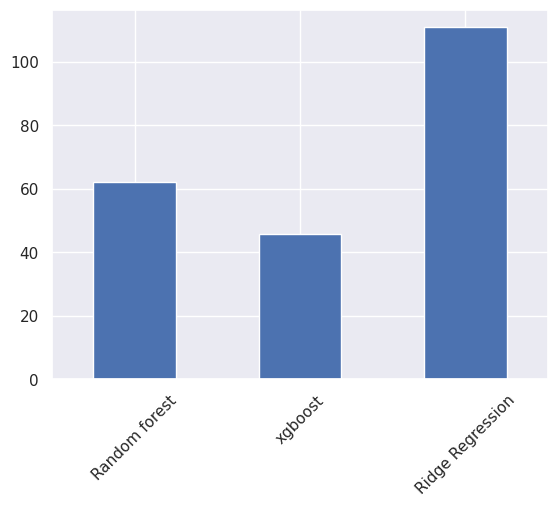

In [36]:
def show_cv_scores(model):
  sns.set()
  cv_scores_df = np.sqrt(-pd.DataFrame.from_dict(model, orient='index'))
  cv_scores_df.plot.bar(rot=45, legend=False)
  plt.show()

show_cv_scores(cv_scores_models)

In [37]:
np.sqrt(-pd.DataFrame.from_dict(cv_scores_models, orient='index'))

0
Random forest      62.284161
xgboost            45.836668
Ridge Regression  110.912343

### Determine the Test Set RMSE

In [38]:
def get_predictions(model, X_val, Y_val):
    # Make predictions on the validation set
    predictions = {}
    for key, value in model.items():
      predictions[key] = model[key].best_estimator_.predict(X_val)
    return predictions


In [39]:
def get_final_rmse(predictions, Y_val):
  rmse_dict = {}
  for key, value in predictions.items():
    mse = mean_squared_error(Y_val, value)
    rmse_dict[key] = np.sqrt(mse)
  return rmse_dict

In [40]:
predictions_models = get_predictions(models, X_test, Y_test.values.ravel())
rmse_score_models = get_final_rmse(predictions_models, Y_test.values.ravel())

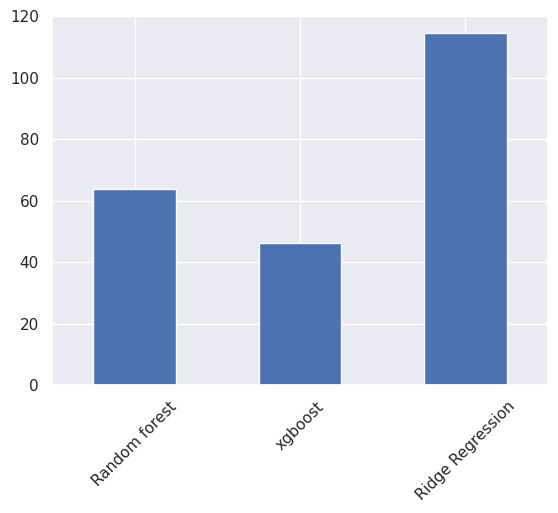

In [41]:
display_predictions(rmse_score_models)

In [42]:
rmse_score_models

{'Random forest': 63.65694176934797,
 'xgboost': 46.24275190833403,
 'Ridge Regression': 114.34985383447072}

## Feature Importance

In [43]:
feature_importance_dict = {}

In [44]:
# Feature Importance for Tree Based

def find_tree_feature_importance(model, columns):
  importance = model.best_estimator_.feature_importances_
  importance *= 100 / np.max(importance)
  importance = pd.DataFrame(importance, index=columns, columns=["Importance"])
  importance = importance.sort_values(by=['Importance'], ascending=False)
  return importance

In [45]:
feature_importance_dict['Random forest'] = find_tree_feature_importance(models['Random forest'], X.columns)
feature_importance_dict['xgboost'] = find_tree_feature_importance(models['xgboost'], X.columns)

In [46]:
# Feature Importance for Regression

def find_normalized_lr_feature_importance(model, x_train, columns):
    coefficients = {columns[i]: np.abs(model.coef_[i]) for i in range(len(columns))}
    coefficients_df = pd.DataFrame.from_dict(coefficients, orient='index', columns=['Importance'])

    # Scale by the standard deviation of the original unscaled features
    #coefficients_df['Importance'] *= x_train.std(axis=0)

    # Normalize the importance values
    coefficients_df['Importance'] *= 100 / coefficients_df['Importance'].max()

    importance = coefficients_df.sort_values(by=['Importance'], ascending=False)
    return importance

In [47]:
feature_importance_dict['Ridge Regression'] = find_normalized_lr_feature_importance(models['Ridge Regression'].best_estimator_ , X_train, X.columns)

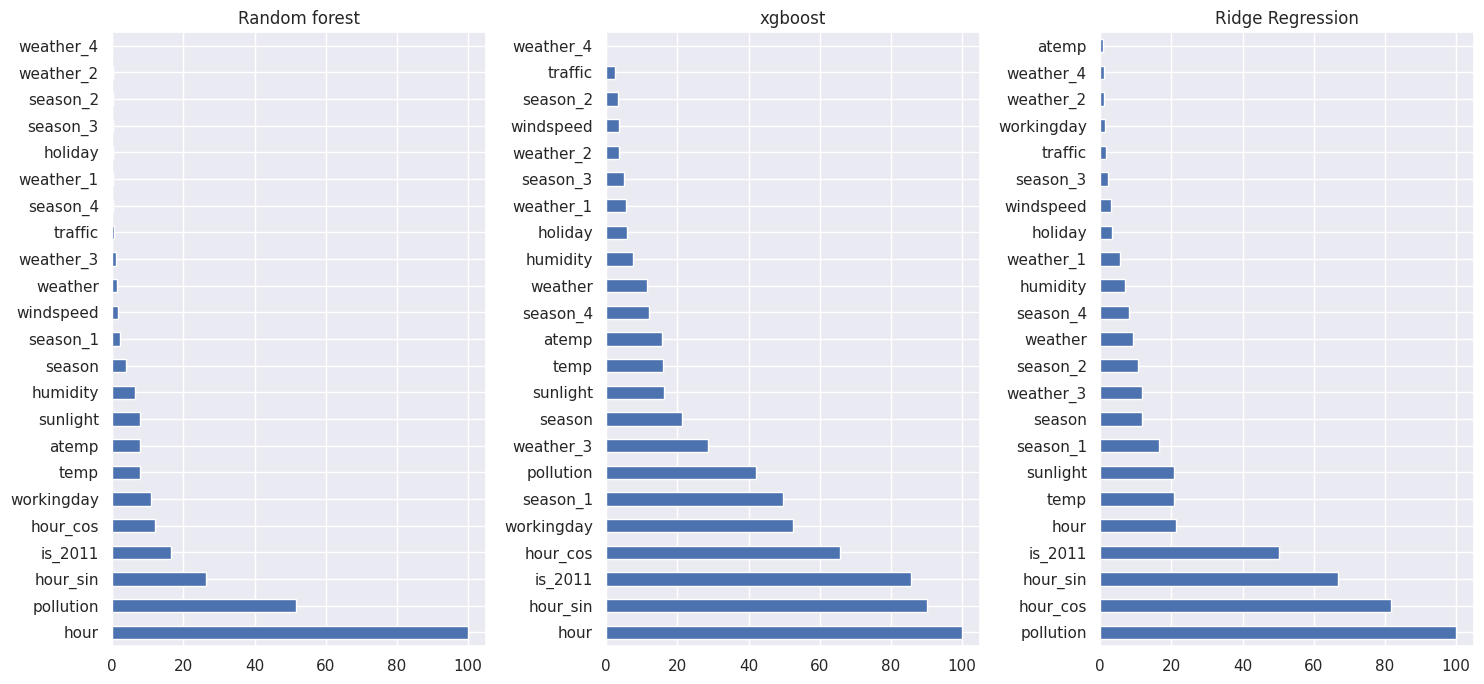

In [48]:
sns.set()

fig, axes = plt.subplots(1, 3, figsize=(15, 7))

feature_importance_dict['Random forest'].plot(kind='barh', ax=axes[0], legend=False, title='Random forest')
feature_importance_dict['xgboost'].plot(kind='barh', ax=axes[1], legend=False, title='xgboost')
feature_importance_dict['Ridge Regression'].plot(kind='barh', ax=axes[2], legend=False, title='Ridge Regression')

plt.tight_layout()
plt.show()

In [49]:
def feature_selection(feature_importance_dict):
  threshold = 3  # Set importance threshold value
  selected_features = {}
  for model in feature_importance_dict:
    selected_features[model] = feature_importance_dict[model][feature_importance_dict[model]['Importance'] > threshold].index.tolist()
  return selected_features

In [50]:
selected_features = feature_selection(feature_importance_dict)

In [51]:
# Assign feature names to X_train and _test
X_train.columns = X.columns
X_test.columns = X.columns

In [52]:
# Train
train = pd.read_csv(url_train)
# Test
test = pd.read_csv(url_test)

In [53]:
def pipeline(train, test, features, model):

      train = tidy_dataset(train)
      test = tidy_dataset(test)

      train = create_dummies(train)
      test = create_dummies(test)

      Y_train = train[['rentals']]
      X_train = train.drop(['rentals'], axis=1)
      Y_test = test[['rentals']].values.ravel()
      X_test = test.drop(['rentals'], axis=1)


      selected_df_test = X_test[features].copy()
      selected_df_train = X_train[features].copy()

      selected_df_train, selected_df_test = scaling_data (selected_df_train, selected_df_test)

      model.fit(selected_df_train, Y_train)
      predictions = model.predict(selected_df_test)
      print(predictions)
      mse = mean_squared_error(Y_test,predictions )
      rmse = np.sqrt(mse)
      print(rmse)
      return rmse , features, model

In [54]:
rmse_score_models

{'Random forest': 63.65694176934797,
 'xgboost': 46.24275190833403,
 'Ridge Regression': 114.34985383447072}

## Random Forest

In [55]:
start_time_rf = clock.time()

In [56]:
#random forest
# Keep only relevant features
rf_df = X_train[selected_features['Random forest']].copy()
rf_df_test = X_test[selected_features['Random forest']].copy()

# Fit model
final_rf = run_random_forest(rf_df, Y_train)
# Best Estimator (Hyperparameters)
best_est_rf = final_rf.best_estimator_
# Best Hyperparameters
best_est_rf = final_rf.best_params_
# Predict
predictions_rf = final_rf.best_estimator_.predict(rf_df_test)
#Final training RMSE
rmse_rf = np.sqrt(mean_squared_error(Y_test, predictions_rf))
#predict on test data
rmse_rf , selected_features_rf, model_rf = pipeline(train, test, selected_features['Random forest'], final_rf.best_estimator_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 2}


<ipython-input-53-d092faa68f2e>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(selected_df_train, Y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[159.67071216   8.85793627 176.56561572 ...  23.13903577 113.34748642
  78.52440641]
56.15084019428151


In [57]:
end_time_rf = clock.time()
elapsed_time_rf = (end_time_rf - start_time_rf)

print("Elapsed time random forest: ", elapsed_time_rf, "sec")

Elapsed time random forest:  462.12491154670715 sec


## XGBoost

In [58]:
start_time_xg = clock.time()

In [59]:
# Keep only relevant features on X_train for each model
xgboost_df = X_train[selected_features['xgboost']].copy()
# Fit models
final_xgboost = run_xgboost_regression(xgboost_df, Y_train)
# Keep only relevant features on X_test for each model
xgboost_df_test = X_test[selected_features['xgboost']].copy()
# Best Estimators (Hyperparameters)
best_xgboost = final_xgboost.best_estimator_
# Predict
predictions_xgboost = final_xgboost.best_estimator_.predict(xgboost_df_test)
# Final RMSE
rmse_xgboost = np.sqrt(mean_squared_error(Y_test, predictions_xgboost))
# Predict on test data
rmse , selected_features_, model = pipeline(train, test, selected_features['xgboost'],final_xgboost.best_estimator_ )

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:45:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:45:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:45:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:45:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[132.09328   17.786976 157.82185  ...  19.100428 119.76859  141.71793 ]
40.76516105024253


In [60]:
end_time_xg = clock.time()
elapsed_time_xg = (end_time_xg - start_time_xg)

print("Elapsed time random forest: ", elapsed_time_xg, "sec")

Elapsed time random forest:  173.77512454986572 sec


## Ridge Regression

In [61]:
start_time_rr = clock.time()

In [62]:
# Keep only relevant features on X_train for each model
ridge_df = X_train[selected_features['Ridge Regression']].copy()
# Fit models
final_ridge = run_ridge_regression(ridge_df, Y_train)
# Keep only relevant features on X_test for each model
ridge_df_test = X_test[selected_features['Ridge Regression']].copy()
# Best Estimators (Hyperparameters)
best_ridge = final_ridge.best_estimator_
# Predict
predictions_ridge = final_ridge.best_estimator_.predict(ridge_df_test)
# Final RMSE
rmse_ridge = np.sqrt(mean_squared_error(Y_test, predictions_ridge))
# Predict on test data
rmse_rr , selected_features_rr, model_rr = pipeline(train, test, selected_features['Ridge Regression'], final_ridge.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[[241.62592315]
 [ 18.09038751]
 [208.9324707 ]
 ...
 [ 55.81397038]
 [127.44648672]
 [156.31933759]]
108.98390757989414


In [63]:
end_time_rr = clock.time()
elapsed_time_rr = (end_time_rr - start_time_rr)

print("Elapsed time random forest: ", elapsed_time_rr, "sec")

Elapsed time random forest:  0.32860898971557617 sec


In [64]:
rmse_score_models

{'Random forest': 63.65694176934797,
 'xgboost': 46.24275190833403,
 'Ridge Regression': 114.34985383447072}

# Results

In [65]:
df = pd.read_csv(url_train)

# Dropped and created features
origin_features = set(df.columns)
origin_features.remove('count')  # Remove 'count' from the set

rf_features = selected_features['Random forest']
xgboost_features = selected_features['xgboost']
rr_features = selected_features['Ridge Regression']

# Features dropped for each model
rf_dropped_features = list(origin_features - set(rf_features))
xgboost_dropped_features = list(origin_features - set(xgboost_features))
rr_dropped_features = list(origin_features - set(rr_features))

# New features created for each model
rf_new_features = list(set(rf_features) - origin_features)
xgboost_new_features = list(set(xgboost_features) - origin_features)
rr_new_features = list(set(rr_features) - origin_features)



In [66]:
# Top 3 features by explainability
rf_top3 = feature_importance_dict['Random forest'].index.tolist()[0:3]
xgboost_top3 = feature_importance_dict['xgboost'].index.tolist()[0:3]
rr_top3 = feature_importance_dict['Ridge Regression'].index.tolist()[0:3]

In [67]:
results = {'model': ['Random forest', 'XG boost', 'Ridge Regression'],
           'Score (RMSE)': [rmse_rf, rmse, rmse_rr],
           'Hyperparams used': [model_rf, model, model_rr],
           'Features dropped': [rf_dropped_features, xgboost_dropped_features, rr_dropped_features],
           'New features created': [rf_new_features, xgboost_new_features, rr_new_features],
           'Runtime trainining + inference (seconds)': [elapsed_time_rf, elapsed_time_xg, elapsed_time_rr],
           'Hardware used (GPU/CPU/TPU)': ['CPU', 'CPU', 'CPU'],
           'Explainability (top 3 features)': [rf_top3, xgboost_top3, rr_top3]
           }

In [68]:
df_results = pd.DataFrame(results)
df_results

model  Score (RMSE)  \
0     Random forest     56.150840   
1          XG boost     40.765161   
2  Ridge Regression    108.983908   

                                    Hyperparams used  \
0  (DecisionTreeRegressor(max_depth=10, max_featu...   
1  XGBRegressor(base_score=None, booster=None, ca...   
2                                  Ridge(alpha=10.0)   

                                   Features dropped  \
0  [windspeed, traffic, holiday, weather, datetime]   
1                               [datetime, traffic]   
2            [datetime, atemp, workingday, traffic]   

                                New features created  \
0                [hour_sin, hour, is_2011, hour_cos]   
1  [weather_3, weather_2, hour, weather_1, is_201...   
2  [weather_3, hour, weather_1, is_2011, season_4...   

   Runtime trainining + inference (seconds) Hardware used (GPU/CPU/TPU)  \
0                                462.124912                         CPU   
1                                173.775125                         CPU   
2                                  0.328609                         CPU   

   Explainability (top 3 features)  
0      [hour, pollution, hour_sin]  
1        [hour, hour_sin, is_2011]  
2  [pollution, hour_cos, hour_sin]

In [69]:
# df_results to CSV
import os
df_results.to_csv(os.path.join(os.getcwd(), 'exercise1.csv'))

In [70]:
print(os.getcwd())

/content
